<a href="https://colab.research.google.com/github/Rachelorange/Lamas-Survey/blob/main/Survey_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C:\Users\User\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


הקובץ נטען בהצלחה...
כמות שורות: 201
כמות עמודות: 18


--- פירוט עמודות וסוגי הנתונים ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 200 non-null    float64       
 1   YeshuvAvoda        200 non-null    object        
 2   ShemAvoda          200 non-null    object        
 3   SugAvoda           175 non-null    object        
 4   ShemMachlaka       136 non-null    object        
 5   SugMachlaka        66 non-null     object        
 6   EzoAvoda           193 non-null    object        
 7   TeurPeula          64 non-null     object        
 8   TeurTafkid         28 non-null     object        
 9   MenahelEtMi        33 non-null     float64       
 10  MaamadAvoda        198 non-null    float64       
 11  MakorSachar        186 non-null    float64       
 12  TeudaGvoha         198 non-nul

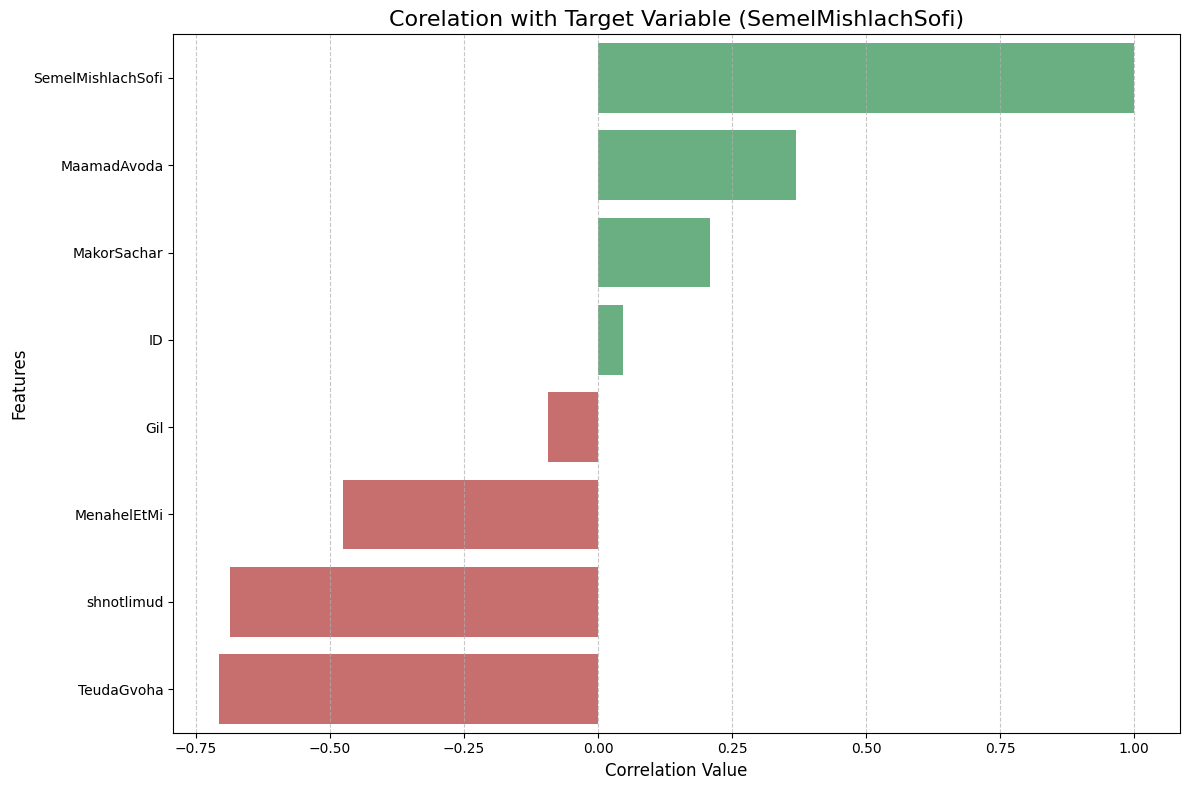

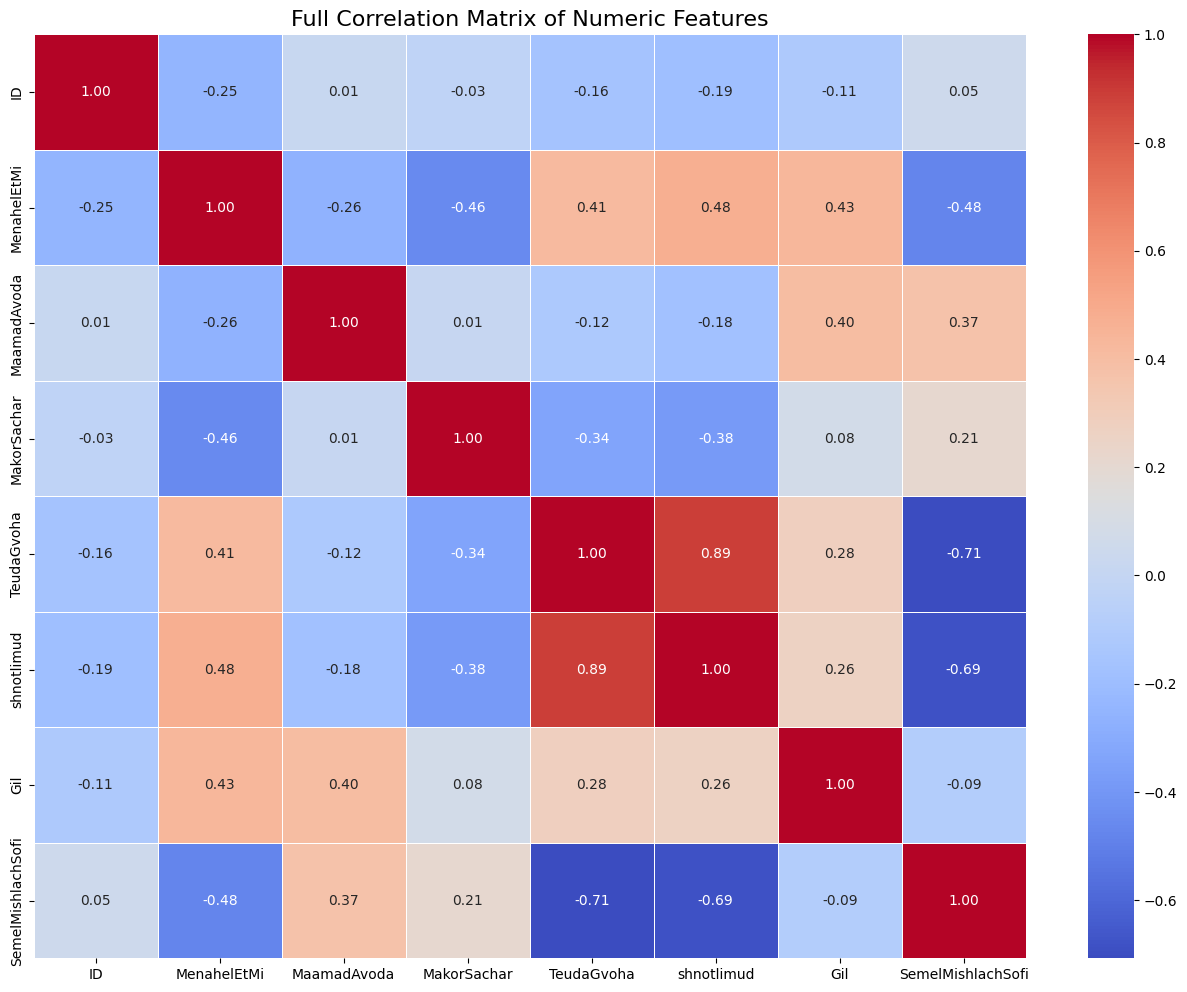


--- 10 דוגמאות מהטבלה לאחר הסיווג המתקדם ---
                                            text_all  industry_category   industry_text_category  management_category management_text_category
0  למ"ס איסוף, עיבוד ופרסום נתונים מיקרו כלכלה טי...                  2  פיננסים ושירותים עסקיים                    2             הנהלה ביניים
1  בית חולים הדסה עין כרם טיפול בחולים רדיואתרפיה...                  6            בריאות ורווחה                    0                עובד רגיל
2  קריית הממשלה מתן שירות למשתמשים באתר GOV תמיכה...                  0         הייטק וטכנולוגיה                    0                עובד רגיל
3     משרד החינוך בית ספר יסודי שמירה שומר בבית הספר                  4             חינוך והוראה                    0                עובד רגיל
4  אמיר כהן מטפל בקשיש במשפחה מטפל בקשיש נותן אוכ...                  4             חינוך והוראה                    0                עובד רגיל
5                                    משטרה שוטר שוטר                  5            ביטחון ושמירה

In [1]:
# pip install pandas matplotlib seaborn openpyxl sentence-transformers scikit-learn transformers torch xgboost spacy==3.4.0 spacy-transformers
# python -m spacy download he_core_news_lg

import pandas as pd
import io
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
# import spacy
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings('ignore')
ner_model = pipeline("ner", model="avichr/heBERT_NER", grouped_entities=True)
# ner_model = spacy.load('he_core_news_lg') #'onlplab/alephbert-base')
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

INDUSTRY_DESCRIPTIONS = {
    'הייטק וטכנולוגיה': 'עבודה בפיתוח תוכנה, חומרה, סייבר, בדיקות תוכנה או ניהול רשתות',
    'קמעונאות ומסחר': 'עבודה במכירות, שיווק, ניהול חנות או שירות לקוחות בתחום המסחר,קופאי, עובד בקניון, מוכרת',
    'פיננסים ושירותים עסקיים': 'עבודה בבנקאות, הנהלת חשבונות, ייעוץ כלכלי, ביטוח או שוק ההון, בנק',
    'אירוח ומזון': 'עבודה במסעדה, בית מלון, בית קפה, בר או שירותי הסעדה',
    'חינוך והוראה': 'עבודה כמורה בבית ספר, גננת, מרצה באקדמיה או הדרכה',
    'ביטחון ושמירה': 'עבודה במשטרה, צבא, חברת אבטחה או תפקידי ביטחון שונים',
    'בריאות ורווחה': 'עבודה בבית חולים, קופת חולים, עבודה סוציאלית או מקצועות הטיפול, קוסמטיקה',
    'תעשייה ובנייה': 'עבודה במפעל ייצור, אתר בנייה, טכנאות, הנדסה או תחזוקה'
}


MANAGEMENT_LEVEL_DESCRIPTIONS = {
    'עובד רגיל': ['עובד', 'חשמלאי','קופאי','טכנאי','קוסמטיקאי','מתכנת'],
    'ראש צוות': ['ראש צוות', 'מוביל', 'אחראי', 'מנהל צוות'],
    'הנהלה ביניים': ['מנהל יחידה','מנהל אגף','מנהל מחלקה','מנהל פרויקט', 'מנהל מוצר','מנהל אזור'],
    'הנהלה בכירה': ['הנהלה בכירה','נשיא','מנהל חטיבה','מנכ"ל', 'סמנכ"ל', 'דירקטור']
}

EDUCATION_LEVEL = ['תיכוני', 'על תיכוני', 'תואר שני', 'דוקטורה']

target_column_name = 'SemelMishlachSofi'
colunm_order = ['ID',
                'YeshuvAvoda',
                'ShemAvoda',
                'SugAvoda',
                'ShemMachlaka',
                'SugMachlaka',
                'EzoAvoda',
                'TeurPeula',
                'TeurTafkid',
                'text_all',
                'industry_text_category',
                'industry_category',
                'management_text_category',
                'management_category',
                'MenahelEtMi',
                'MaamadAvoda',
                'MakorSachar',
                'TeudaGvoha',
                'shnotlimud',
                'Gil',
                'Gil_Category_text',
                'Gil_Category',
                'TarichHathala',
                'vetek_Years',
                'vetek_Category_text',
                'vetek_Category',
                'SemelAnafSofi',
                'SemelMishlachSofi'
]


def load_dataset():
    file_path = 'DataSet_Final.xlsx'

    try:
        survey_df = pd.read_excel(file_path, sheet_name='Survey Dataset')
        print('הקובץ נטען בהצלחה...')
        print(f"כמות שורות: {len(survey_df)}")
        print(f"כמות עמודות: {len(survey_df.columns)}")
        print("\n")

        return survey_df

    except FileNotFoundError:
        print(f"שגיאה: הקובץ '{file_path}' לא נמצא.")
        return None
    except Exception as e:
        print(f"אירעה שגיאה בטעינת הקובץ: {e}")
        return None


def get_info(df):

    buffer = io.StringIO()
    df.info(buf=buffer)
    info_str = buffer.getvalue()
    print("--- פירוט עמודות וסוגי הנתונים ---")
    print(info_str)
    print("\n")

    # --- רשומות כפולות ---
    duplicate_rows = df.duplicated().sum()
    print("--- רשומות כפולות ---")
    print(f"מספר הרשומות הכפולות: {duplicate_rows}")
    print("\n")

    # --- ערכים חסרים ---
    missing_values = df.isnull().sum()
    missing_values_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({'NUMB': missing_values, 'PERCENT': missing_values_percent})
    missing_df = missing_df[missing_df['NUMB'] > 0].sort_values(by='NUMB', ascending=False)
    print("--- עמודות עם ערכים חסרים ---")
    if not missing_df.empty:
        print(missing_df)
    else:
        print("לא נמצאו ערכים חסרים בנתונים.")
    print("\n")

    # --- ניתוח עמודות קטגוריאליות ---
    print("--- ניתוח עמודות קטגוריאליות  ---")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        value_counts = df[col].value_counts(dropna=False)
        print(f"מתוך {df[col].notna().sum()} ערכים שהוזנו, כמות מופעים   {col} : {len(value_counts)} ")
        print(value_counts.head(10))
        print("-" * 20)
        print("\n")

    # --- סטטיסטיקות תיאוריות לעמודות מספריות ---
    print("--- סטטיסטיקות תיאוריות לעמודות מספריות ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)  # הרחבת רוחב התצוגה הכולל
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print(df.describe())
    print("\n")


def plot_corr_data(df):
    #  עמודות מספריות בלבד לחישוב קורלציה
    df[target_column_name] = pd.to_numeric(df[target_column_name], errors='coerce')
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(12, 8))
    target_corr = corr_matrix[target_column_name].sort_values(ascending=False)
    # מבעים לערכים חיוביים ושליליים
    colors = ['#d65f5f' if c < 0 else '#5fba7d' for c in target_corr.values]
    sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)

    plt.title(f'Corelation with Target Variable ({target_column_name})', fontsize=16)
    plt.xlabel('Correlation Value', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # הצגת Heatmap של כל המשתנים
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Full Correlation Matrix of Numeric Features', fontsize=16)
    plt.show()


def classify_category_embedding(text_to_process, category_embeddings, category_names):

    # חלוקה לקטגוריות עם Embeddings

    org_embedding = embedding_model.encode([text_to_process])
    similarities = cosine_similarity(org_embedding, category_embeddings)
    best_category_index = np.argmax(similarities)
    # print(text_to_process, 'קבוצה: ', best_category_index,' - ', category_names[best_category_index])

    return best_category_index, category_names[best_category_index]


def text_to_group(df):
    # יצירת וקטורים לתיאורי הקטגוריות
    industry_names_list = list(INDUSTRY_DESCRIPTIONS.keys())
    industry_descriptions_list = list(INDUSTRY_DESCRIPTIONS.values())
    industry_embeddings_tensor = embedding_model.encode(industry_descriptions_list)

    # איחוד שדות הטקסט
    cols_to_join =['ShemAvoda', 'SugAvoda', 'ShemMachlaka', 'SugMachlaka', 'EzoAvoda', 'TeurPeula', 'TeurTafkid']
    df['text_all'] = df[cols_to_join].fillna('').astype(str).agg(' '.join, axis=1)
    df['text_all'] = df['text_all'].str.replace(r'\s+', ' ', regex=True).str.strip() #ניקוי רווחים


    industry_categories = []
    industry_text_categories = []
    management_categories = []
    management_text_categories = []
    ordered_categories = ['עובד רגיל', 'ראש צוות', 'הנהלה ביניים', 'הנהלה בכירה']

    # מעבר על כל שורה בדאטה פריים באמצעות לולאה
    for index, row in df.iterrows():
        text_to_process = row['text_all']

        if text_to_process and text_to_process.strip():

            # הכנה לאיתור ווקטורי
            industry_cat, industry_text_cat = classify_category_embedding(text_to_process, industry_embeddings_tensor, industry_names_list)
            industry_categories.append(industry_cat)
            industry_text_categories.append(industry_text_cat)

            # NER - זיהוי יישויות
            # המודל לא מזהה טוב יישויות כדון מקצוע, כישורים, תפקיד ומקום עבודה
            # יש צורך לאמן את המודל כך שיכיר את היישויות האלו
            # לא מתאפשר לי מבחינת הזמן - לכן עןברת לפתרון ב'
            # ner_results = ner_model(text_to_process)
            # extracted_org = None
            # for entity in ner_results:
            #     # איתור ארגון
            #     if entity['entity_group'] == 'B_ORG':
            #         extracted_org = entity['word']
            #         break

            # איתור האם מנהל לפי מילת מפתח
            tmp_management_categories = ordered_categories.index('עובד רגיל')
            tmp_management_text_categories = 'עובד רגיל'
            management_found = False
            for management_cat in ordered_categories:
                keyword_list = MANAGEMENT_LEVEL_DESCRIPTIONS[management_cat]
                for keyword in keyword_list:
                    if keyword in text_to_process:
                        tmp_management_categories = ordered_categories.index(management_cat)
                        tmp_management_text_categories = management_cat
                        management_found = True
                        break  # יציאה מהלולאה הפנימית לאחר שנמצאה התאמה
                if management_found:
                    break  # יציאה מהלולאה החיצונית

            #  הצלבה נוספת אם הקטגוריה היא 'עובד רגיל'
            if tmp_management_categories == 0 or not tmp_management_categories :  # אם עובד רגיל, תבדוק מי מנהל
                menahel_et_mi_value = row.get('MenahelEtMi')
                if menahel_et_mi_value == 2:  # מנהל מנהלים -> הנהלה בכירה
                    tmp_management_categories = ordered_categories.index('הנהלה בכירה')
                    tmp_management_text_categories = 'הנהלה בכירה'
                elif menahel_et_mi_value == 3:  # מנהל עובדים ומנהלים -> הנהלה ביניים
                    tmp_management_categories = ordered_categories.index('הנהלה ביניים')
                    tmp_management_text_categories = 'הנהלה ביניים'
                elif menahel_et_mi_value == 1:  # מנהל עובדים -> ראש צוות
                    tmp_management_categories = ordered_categories.index('ראש צוות')
                    tmp_management_text_categories = 'ראש צוות'

            management_categories.append(tmp_management_categories)
            management_text_categories.append(tmp_management_text_categories)

        else:
            industry_categories.append("-1")
            industry_text_categories.append("אין מידע")
            management_categories.append("-1")
            management_text_categories.append("אין מידע")

    # איתור ווקטורי המשך: השמת רשימת התוצאות לעמודה החדשה
    df['industry_category'] = industry_categories
    df['industry_text_category'] = industry_text_categories
    df['management_category'] = management_categories
    df['management_text_category'] = management_text_categories

    print("\n--- 10 דוגמאות מהטבלה לאחר הסיווג המתקדם ---")
    print(df[['text_all', 'industry_category','industry_text_category','management_category','management_text_category']].head(10))

    print("\n--- התפלגות הענפים שסווגו ---")
    print(df['industry_category'].value_counts(),df['management_category'].value_counts())


    return df


def calculate_new_colunms(df):

    # calculate year seniority
    print("--- Calculate Seniority ---")
    df['TarichHathala_dt'] = pd.to_datetime(df['TarichHathala'], errors='coerce') # check if date
    vetek_days = (pd.to_datetime('today') - df['TarichHathala_dt'])
    df['vetek_Years'] = (vetek_days.dt.days / 365).astype(int)
    df.drop(columns=['TarichHathala_dt'], inplace=True)  # drop  temporary column

    print("'vetek_Years' column created.")
    print(df[['TarichHathala', 'vetek_Years']].head())
    print("\n")

    # הוספת קבוצת גיל
    age_bins = [0, 17, 25, 50, 120]  # קבוצות גילאים  (18-25,0-17, 26-50, 51+)
    age_labels = ['קטין', 'צעיר', 'בוגר', 'מבוגר']
    df['Gil_Category_text'] = pd.cut(df['Gil'], bins=age_bins, labels=age_labels, right=True)
    df['Gil_Category'] = df['Gil_Category_text'].cat.codes

    print("'Gil_Category' column created.")
    print(df[['Gil', 'Gil_Category', 'Gil_Category_text']].head())
    print("\n")

    # הוספת קבוצת וותק
    vetek_bins = [-1, 1, 5, 10, 100]  # קצוות הטווחים (0-1, 2-5 ,6-10, 11+)
    vetek_labels = ['וותק מתחיל', 'וותק נמוך', 'וותק בינוני', 'וותק גבוה']
    df['vetek_Category_text'] = pd.cut(df['vetek_Years'], bins=vetek_bins, labels=vetek_labels, right=True)
    df['vetek_Category'] = df['vetek_Category_text'].cat.codes

    print("'vetek_Category' column created.")
    print(df[['vetek_Years', 'vetek_Category', 'vetek_Category_text']].head())
    print("\n")

    return df


def main():

    df = load_dataset()
    if df is None:
        exit()

    # בדיקה וניתוח נתונים
    get_info(df)

    # מחיקת רשומות ללא משתנה המטרה
    numb_rows_before_delete = len(df)
    df.dropna(subset=[target_column_name], inplace=True) # ללא ערך
    df = df[df[target_column_name] != 'XXXX'] # ערך לא תקין
    numb_rows_after_delete = len(df)
    print('----- מחיקת רשומות ללא משתנה מטרה-----')
    print(f"Removed {numb_rows_before_delete - numb_rows_after_delete} rows.")
    print(f"Total rows remaining: {numb_rows_after_delete}")

    # הצגת קורלציה עם משתנה המטרה
    plot_corr_data(df)

    # חלוקת תיאור שדות העבודה לקבוצות
    df = text_to_group(df)

    # הוספת שדות מחושבים חשובים למודל
    df = calculate_new_colunms(df)

    #שמירת הנתונים לאקסל
    df = df[colunm_order]
    df.to_excel("Survey_File_Part1.xlsx", index=False, sheet_name='Survey New ds')
    print('הקובץ נשמר בהצלחה !!!')


if __name__ == "__main__":
    main()






